In [24]:
import numpy as np, pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
train = pd.read_csv('../input/all/train.csv', index_col='Id')
test = pd.read_csv('../input/all/test.csv', index_col='Id')

In [26]:
tr1 = train.index
te2 = test.index

# 处理异常值

<pre>
train里有两个样本生活空间最大却房价很低，可能数据有问题，即使没问题也不应该拿来参考，所以删掉
</pre>

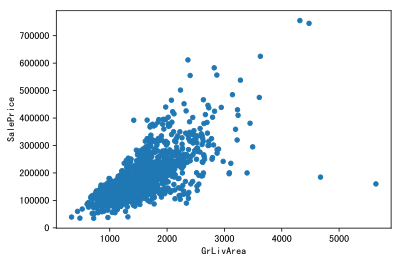

In [27]:
train.plot.scatter(x='GrLivArea', y='SalePrice')

In [28]:
train.drop(train[(train['GrLivArea']>4500)].index, inplace=True)

<pre>
test里有一个样本车库建成时间2207年，应该是2007年打错了，因为他的房子2006年建成2007年"强化"了
</pre>

In [29]:
test['GarageYrBlt'].sort_values(ascending=False).head()

Id
2593    2207.0
1609    2010.0
1503    2010.0
1577    2009.0
1489    2009.0
Name: GarageYrBlt, dtype: float64

In [30]:
test[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].loc[2593]

YearBuilt       2006.0
YearRemodAdd    2007.0
GarageYrBlt     2207.0
Name: 2593, dtype: float64

In [31]:
test['GarageYrBlt'][2593] = 2007

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
train_index = train.index
test_index = test.index

In [33]:
y_train = train.pop('SalePrice')
all_data = pd.concat([train, test], axis=0)

# 处理缺失值

In [34]:
missing_count = all_data.isnull().sum()
missing_count = missing_count[missing_count>0].sort_values(ascending=False)
DataFrame({'counts':missing_count, 'type':train.dtypes[missing_count.index]})\
            .sort_values(by=['type','counts'], ascending=False)

,counts,type
PoolQC,2908,object
MiscFeature,2812,object
Alley,2719,object
Fence,2346,object
FireplaceQu,1420,object
GarageFinish,159,object
GarageQual,159,object
GarageCond,159,object
GarageType,157,object
BsmtExposure,82,object


### 

<pre>
数据集有一个坑，他里面很多特征的值就是NA，表示没有这个东西，而他们记录缺失值也用NA
对于那些值域不包含NA的变量我们可以确定他的NA是缺失值
但是可以填NA的特征就不能区分了，就只能尽量从逻辑上判断是否有缺失值（有的样本不可能填NA），其他都当作填的是NA，把他们全替换成'None'

还有一类缺失值：
数据描述里说了，默认Functional为typical

这些变量是值域不包含NA的：
MSZoning
Utilities
+Exterior2nd
+Exterior1st
+SaleType
+Electrical
+KitchenQual
</pre>

In [35]:
all_data['Functional'].fillna('Typ', inplace=1)

### MasVnrType
<pre>
MasVnrType 有一个样本这个为nan但是masvnrarea为189，说明这个可以补,选择非None的BrkFace，因为它的数量最多，同时中位数也较接近189
            其它的就不清楚了，因为剩下23个masvnrtype和area都是nan，我认为这些房子没有砌体单板墙的几率很小
            因为感觉这个一定程度和OverallQual相关，事实上确实没有砌体单板墙的房子
            OverallQual（对房子装修和完成度的评价）比有的差了一截，但这23个样本的评价在平均值之上
            所以我试一下，一次用平均数和众数，一次全当作没有，填'none'和0
</pre>

In [36]:
all_data['MasVnrType'].value_counts()

None       1742
BrkFace     879
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

In [37]:
all_data.groupby('MasVnrType')['MasVnrArea'].median()

MasVnrType
BrkCmn     161.0
BrkFace    203.0
None         0.0
Stone      200.0
Name: MasVnrArea, dtype: float64

### MasVnrType

In [38]:
all_data['OverallQual'][all_data['MasVnrType']=='None'].describe()

count    1742.000000
mean        5.613662
std         1.250157
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max        10.000000
Name: OverallQual, dtype: float64

In [39]:
all_data['OverallQual'][(all_data['MasVnrType']!='None')&(all_data['MasVnrType'].notnull())].describe()

count    1151.000000
mean        6.779322
std         1.335127
min         3.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: OverallQual, dtype: float64

In [40]:
all_data['OverallQual'][all_data['MasVnrType'].isnull()].describe()

count    24.000000
mean      7.166667
std       1.129319
min       4.000000
25%       7.000000
50%       7.000000
75%       8.000000
max      10.000000
Name: OverallQual, dtype: float64

In [41]:
all_data[['MasVnrType', 'MasVnrArea']][(all_data['MasVnrType'].isnull())&(all_data['MasVnrArea'].notnull())]

,MasVnrType,MasVnrArea
Id,,
2611,NaN,198.0


In [42]:
all_data['MasVnrType'].loc[2611]='BrkFace'

/usr/lib/python3/dist-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# 抉择1

In [43]:
#all_data['MasVnrType'].fillna('BrkFace', inplace=1)
#all_data['MasVnrArea'].fillna(all_data['MasVnrArea'].mean(), inplace=1)
all_data['MasVnrType'].fillna('None', inplace=1)
all_data['MasVnrArea'].fillna(0, inplace=1)

### MSZoning

In [44]:
all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0], inplace=1)

### Utilities
<pre>
基本除了一个样本是NoSeWa其他都是allpub，并且这两个样本供暖都是用的GasA，电力系统是FuseA，厨房质量中等，用水和下水道肯定要有吧，所以他们就是allpub
</pre>

In [45]:
all_data[['Utilities', 'Electrical', 'KitchenQual', 'Heating']][all_data['Utilities'].isnull()]

,Utilities,Electrical,KitchenQual,Heating
Id,,,,
1916,NaN,FuseA,TA,GasA
1946,NaN,FuseA,TA,GasA


In [46]:
all_data['Utilities'].fillna('AllPub', inplace=1)

### Exterior1st、Exterior2nd
<pre>
首先可以肯定是有外层涂料的，因为涂料质量是TA，就用众数填充
</pre>

In [47]:
all_data[['ExterQual']][all_data['Exterior1st'].isnull()]

,ExterQual
Id,
2152,TA


In [48]:
all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0], inplace=1)
all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0], inplace=1)

### SaleType

In [49]:
all_data['SaleType'].fillna(all_data['SaleType'].mode()[0], inplace=1)

### Electrical

In [50]:
all_data['Electrical'].fillna(all_data['Electrical'].mode()[0], inplace=1)

### KitchenQual
<pre>
这个样本房屋总体质量为5,厨房就用一般水平填充
</pre>

In [51]:
all_data[['KitchenAbvGr','OverallQual']][all_data['KitchenQual'].isnull()]

,KitchenAbvGr,OverallQual
Id,,
1556,1,5


In [52]:
all_data['KitchenQual'].fillna('TA', inplace=1)

<pre>
PoolQc
MiscFeature
Alley
Fence
FireplaceQu
GarageFinsh
GarageQual
GarageCond
GarageType
BsmtExposure
BsmtCond
BsmtQual
BsmtFinType2
BsmtFinType1
</pre>

### PoolQC
<pre>
有三个样本PoolQC没填但是他们填了PoolArea，说明还是有游泳池的，就根据OverallQual来填充吧
其他的就当作没有游泳池，用'None'填充
</pre>

In [53]:
all_data['PoolArea'][(all_data['PoolArea']!=0) & (all_data['PoolQC'].isnull())]

Id
2421    368
2504    444
2600    561
Name: PoolArea, dtype: int64

In [54]:
all_data[['OverallQual', 'PoolQC']].loc[[2421, 2504, 561]]

,OverallQual,PoolQC
Id,,
2421,4,NaN
2504,6,NaN
561,5,NaN


In [55]:
all_data.loc[2421, 'PoolQC'] = 'Fa'
all_data.loc[2504, 'PoolQC'] = 'Gd'
all_data.loc[561, 'PoolQC'] = 'Fa'

### MiscFeature
<pre>
有一个样本MiscFeature没填但是MiscVal为17000，这个是所有MiscVal里最高的，而在所有类别里就车库的价值相对较高，并且我们可以看到他的车库质量和现状都是平均水平，但是有3个车位，所以他有可能有第二个车库（也可能是我想多了）

其他人就当是没有MiscFeature用'None'填充
</pre>

In [56]:
all_data[['MiscFeature', 'MiscVal']][all_data['MiscFeature'].isnull() & (all_data['MiscVal']!=0)]

,MiscFeature,MiscVal
Id,,
2550,NaN,17000


In [57]:
all_data[['GarageCars', 'GarageQual', 'GarageCond']].loc[2550]

GarageCars     3
GarageQual    TA
GarageCond    TA
Name: 2550, dtype: object

In [58]:
all_data.groupby('MiscFeature')['MiscVal'].describe()

MiscFeature       
Gar2         count        5.000000
             mean      8760.000000
             std       5266.687764
             min       3000.000000
             25%       4500.000000
             50%       8300.000000
             75%      12500.000000
             max      15500.000000
Othr         count        4.000000
             mean      3250.000000
             std       2661.453237
             min          0.000000
             25%       2250.000000
             50%       3250.000000
             75%       4250.000000
             max       6500.000000
Shed         count       95.000000
             mean       763.800000
             std        655.701615
             min          0.000000
             25%        410.000000
             50%        500.000000
             75%        700.000000
             max       4500.000000
TenC         count        1.000000
             mean      2000.000000
             std               NaN
             min       2000.000000
 

In [59]:
all_data['MiscFeature'][2550] = 'Gar2'

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 

In [60]:
np.sort(all_data.columns)

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces',
       'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape',
       'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea',
       'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive',
       'PoolArea', 'P

### Garage系列
<pre>
和车库有关的变量里存在缺失值的样本里，有两个不是完全缺失，他们的车库类型填的Detchd，所以应该还是有车库的，就用中位数和众数填充，其他样本所有和车库相关的变量都缺失，就全当作没有车库来处理
</pre>

In [61]:
garage = all_data[['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 
                   'GarageQual', 'GarageType', 'GarageYrBlt']]

In [62]:
garage[(garage.isnull().sum(axis=1)>0)].apply(Series.value_counts)

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
0.0,157.0,157.0,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
360.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Detchd,NaN,NaN,NaN,NaN,NaN,2.0,NaN


In [63]:
garage[(garage.isnull().sum(axis=1)>0)&(garage['GarageType']=='Detchd')]

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
Id,,,,,,,
2127,360.0,1.0,NaN,NaN,NaN,Detchd,NaN
2577,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


In [64]:
all_data['GarageType'].value_counts()

Attchd     1722
Detchd      779
BuiltIn     185
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

In [65]:
all_data['GarageArea'][2577] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].median()
all_data['GarageCars'][2577] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].mode()[0]
all_data['GarageCond'][2127] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].mode()[0]
all_data['GarageCond'][2577] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].mode()[0]
all_data['GarageFinish'][2127] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].mode()[0]
all_data['GarageFinish'][2577] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].mode()[0]
all_data['GarageQual'][2127] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].mode()[0]
all_data['GarageQual'][2577] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].mode()[0]
all_data['GarageYrBlt'][2127] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].median()
all_data['GarageYrBlt'][2577] = all_data['GarageArea'][all_data['GarageType']=='Detchd'].median()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-p

In [66]:
all_data[['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 
                   'GarageQual', 'GarageType', 'GarageYrBlt']].loc[[2127, 2577]]

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
Id,,,,,,,
2127,360.0,1.0,576,576,576,Detchd,399.5
2577,399.5,576.0,576,576,576,Detchd,399.5


#### 剩下的GarageYrBlt
<pre>
所有GarageYrBlt为NA的都是没有车库的，就把他们统作为一类，先赋值为0
</pre>

In [67]:
all_data[(all_data['GarageArea']>0)&(all_data['GarageYrBlt'].isnull())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,


# 抉择2

In [68]:
all_data['GarageYrBlt'].fillna(0, inplace=1)
#all_data['GarageYrBlt'] = \
#all_data.groupby('OverallQual')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

### basement
<pre>
在所有和地下室有关的变量里，缺失值数量大于1的样本所有的值不是0就是nan，所以都把他们认为没有地下室,用'None'或0填充
只有一个缺失值的样本里缺失的都是类别变量，我们可以根据其他相关变量来手动填充

例如：
BsmtFinType2根据BsmtFinSF2估计为ALQ
3个BsmtExposure缺失的地下室都还没建好，就按照绝大多数情况定为'No'
BsmtCond都用TA
BsmtQual缺失的两个值，他们的cond分别是Fa和TA，并且都没有光线也建成所以给Fa和Po


</pre>

In [69]:
bsmt = all_data[['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']]

In [70]:
bsmt[(bsmt.isnull().sum(axis=1)==1)]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
Id,,,,,,,,,,,
333,TA,No,1124.0,479.0,GLQ,NaN,1.0,0.0,Gd,1603.0,3206.0
949,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,936.0,936.0
1488,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,1595.0,1595.0
2041,NaN,Mn,1044.0,382.0,GLQ,Rec,1.0,0.0,Gd,0.0,1426.0
2186,NaN,No,1033.0,0.0,BLQ,Unf,0.0,1.0,TA,94.0,1127.0
2218,Fa,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,173.0,173.0
2219,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,NaN,356.0,356.0
2349,TA,NaN,0.0,0.0,Unf,Unf,0.0,0.0,Gd,725.0,725.0
2525,NaN,Av,755.0,0.0,ALQ,Unf,0.0,0.0,TA,240.0,995.0


In [71]:
all_data.loc[333, 'BsmtFinType2'] = 'ALQ'
all_data.loc[949, 'BsmtExposure'] = 'No'
all_data.loc[1488, 'BsmtExposure'] = 'No'
all_data.loc[2041, 'BsmtCond'] = 'TA'
all_data.loc[2186, 'BsmtCond'] = 'TA'
all_data.loc[2218, 'BsmtQual'] = 'Fa'
all_data.loc[2219, 'BsmtQual'] = 'Po'
all_data.loc[2349, 'BsmtExposure'] = 'No'
all_data.loc[2525, 'BsmtCond'] = 'TA'

### LotFrontage
<pre>
房子到街道的距离，像我们大部分人怕不是都只有几米，只有住在比较闲适或偏僻的地方或距离远一些，所以可以试着根据neighborhood来填充
</pre>

In [72]:
all_data['LotFrontage'] = \
all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

### 扫尾

In [73]:
all_data.loc[:, all_data.columns[all_data.dtypes=='object']] = \
all_data.loc[:, all_data.columns[all_data.dtypes=='object']].fillna('None')

In [74]:
all_data[['BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF']] = \
all_data[['BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF']].fillna(0)

# 新建变量
<pre>
新增4个变量，用来描述总完成的面积、所有类型走廊总面积、是否有第二层和是否有铺置木质地板
</pre>

In [75]:
all_data['total_fin_sf'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + 
                            all_data['2ndFlrSF'])

all_data['total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + 
                              all_data['ScreenPorch'] + all_data['WoodDeckSF'])

all_data['has2ndfloor'] = (all_data['2ndFlrSF']==0)*1
all_data['WoodDeckSF'] = (all_data['WoodDeckSF']==0)*1

# 数据类型转换
<pre>
MSSubClass虽然是数值类型，但实际上各个值并不是连续的关系，所以还是转换成类别数据
Mosold，12个月其实不存在先后顺序吧，应该变成类别数据
</pre>

In [76]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)

# 偏度处理
<pre>
对偏度大于2的特征取log(1+x)
对目标变量也套用log(1+x)
</pre>

In [77]:
from scipy.stats import skew

In [78]:
all_data.loc[:, all_data.columns[all_data.dtypes!='object']].apply(skew).sort_values(ascending=False)

GarageCars        53.568505
MiscVal           21.939672
PoolArea          17.688664
LotArea           13.109495
LowQualFinSF      12.084539
3SsnPorch         11.372080
KitchenAbvGr       4.300550
BsmtFinSF2         4.144503
EnclosedPorch      4.002344
ScreenPorch        3.945101
BsmtHalfBath       3.929996
MasVnrArea         2.621719
OpenPorchSF        2.529358
total_porch_sf     1.379521
1stFlrSF           1.257286
total_fin_sf       1.253666
LotFrontage        1.103039
GrLivArea          1.068750
BsmtFinSF1         0.980645
BsmtUnfSF          0.919688
2ndFlrSF           0.861556
TotRmsAbvGrd       0.749232
Fireplaces         0.725278
HalfBath           0.696666
TotalBsmtSF        0.671751
BsmtFullBath       0.622415
OverallCond        0.569314
BedroomAbvGr       0.326568
GarageArea         0.219112
OverallQual        0.189591
FullBath           0.165514
YrSold             0.131996
WoodDeckSF        -0.088534
has2ndfloor       -0.290292
YearRemodAdd      -0.450134
YearBuilt         -0

In [79]:
loged_features = all_data.loc[:, all_data.columns[all_data.dtypes!='object']].apply(skew)\
.sort_values(ascending=False)[:12].index

all_data[loged_features] = all_data[loged_features].applymap(np.log1p)

In [80]:
all_data.loc[:, all_data.columns[all_data.dtypes!='object']].apply(skew).sort_values(ascending=False)

PoolArea          15.623275
3SsnPorch          8.822116
LowQualFinSF       8.554639
MiscVal            5.212005
BsmtHalfBath       3.773208
KitchenAbvGr       3.518883
ScreenPorch        2.944570
OpenPorchSF        2.529358
BsmtFinSF2         2.461259
EnclosedPorch      1.959952
total_porch_sf     1.379521
1stFlrSF           1.257286
total_fin_sf       1.253666
LotFrontage        1.103039
GrLivArea          1.068750
BsmtFinSF1         0.980645
BsmtUnfSF          0.919688
2ndFlrSF           0.861556
TotRmsAbvGrd       0.749232
Fireplaces         0.725278
HalfBath           0.696666
TotalBsmtSF        0.671751
BsmtFullBath       0.622415
OverallCond        0.569314
MasVnrArea         0.538454
BedroomAbvGr       0.326568
GarageCars         0.251059
GarageArea         0.219112
OverallQual        0.189591
FullBath           0.165514
YrSold             0.131996
WoodDeckSF        -0.088534
has2ndfloor       -0.290292
YearRemodAdd      -0.450134
LotArea           -0.532646
YearBuilt         -0

In [81]:
y_train = np.log1p(y_train)

In [82]:
skew(y_train)

0.12145464268184528

In [83]:
skew(np.log1p(y_train))

-0.008849115910914113

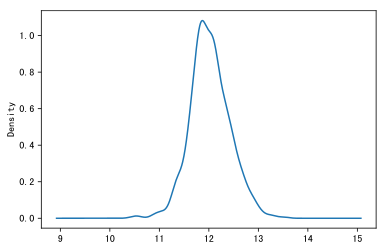

In [84]:
y_train.plot(kind='kde') #一点小偏

In [85]:
all_data.drop(['Utilities', 'Street'], axis=1, inplace=True)

# one-hot

In [86]:
all_data = pd.get_dummies(all_data)

In [87]:
all_data = all_data.drop(['MSSubClass_150', 'BsmtQual_Po'], axis=1)

# 这里我没有做feature_selection

# 数据存起来，下次建模

In [88]:
train_fixed = all_data.loc[train_index]
test_fixed = all_data.loc[test_index]

In [89]:
#y_train.to_csv('y_train.csv', index=False)
#train_fixed.to_csv('train_fixed.csv', index=False)
#test_fixed.to_csv('test_fixed.csv', index=False)